In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab07.ipynb")

# Lab 07: Gradient Descent and Sklearn

In this lab, we will work through the process of:
1. Defining loss functions,
1. Performing feature engineering,
1. Minimizing loss functions using numerical methods and analytical methods,
1. Understanding what happens if we use the analytical solution for OLS on a matrix with redundant features,
1. Computing a gradient for a nonlinear model, and
1. Using gradient descent to optimize the non-linear model.

This lab will continue using the toy `tips` calculation dataset used in a prior lab.

To receive credit for a lab, answer all questions correctly and submit before the deadline.

**The on-time deadline is Tuesday, October 22, 11:59 PM**. As a reminder, the slip-day policy does not apply to labs. We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline. This way, you will have ample time to contact staff for submission support.

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

**Note:** Some parts of the video are recorded in Spring 2022. There may be slight inconsistencies between the version you are viewing and the version used in the recording, but the content is identical.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("LohVOmiulHQ")


### Collaboration Policy

Data science is a collaborative activity. While you may talk to others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the following cell:

**Collaborators**: *list names here*

---
### Debugging Guide

If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). In this guide, you can find general questions about Jupyter notebooks / Datahub, Gradescope, and common `pandas`, RegEx, and visualization errors.

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Feature Engineering

To begin, let's load the tips dataset from the `seaborn` library.  This dataset contains records of tips, total bill, and information about the person who paid the bill. As earlier, we'll be trying to predict tips from the other data.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")
%matplotlib inline

In [3]:
# Run this cell to load the tips dataset; no further action is needed.
data = sns.load_dataset("tips")

print("Number of Records:", len(data))
data.head()

Number of Records: 244


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


---

## Feature Functions

So far, we've only considered models of the form $\hat{y} = f_{\theta}(x) = \theta_0 + \sum_{j=1}^p x_j\theta_j$, where $\hat{y}$ is a quantitative continuous variable. 

We call this a linear model because it is a linear combination of the features $x_1, \dots, x_p$. However, our features don't need to be numbers: we could have categorical values such as names. Additionally, the true relationship doesn't have to be linear, as we could have a relationship that is quadratic, such as the relationship between the height of a projectile and time.

In these cases, we often apply **feature functions**, functions that take in some value and output another value. This might look like converting a string into a number, combining multiple numeric values, or creating a boolean value from some filter.

If we use $\phi$ to represent the feature (_"phi"_-ture) function or transformation applied to our data, then our model takes the following form: $$\hat{y} = f_{\theta}(x) = \theta_0 + \sum_{j=1}^p \phi(x)_j\theta_j$$

### Example Feature Functions

1. **One-hot encoding**
    - Converts a single categorical feature into many binary features, each of which represents one of the possible values in the original column.
    - Each of the binary feature columns produced contains a 1 for rows that had that column's label in the original column and 0 elsewhere.
1. **Polynomial feature**
    - Creates polynomial combinations of features.
1. **Normalized/Standardized feature**
    - Normalizes features so they have a mean of 0 and a standard deviation of 1.

<br/>
<hr style="border: 1px solid #fdb515;" />

## Defining the Model and Engineering Features

In Lab 5, we used both a Simple Linear Regression (SLR) model and a constant model on this dataset. Now, let's make a more complicated model that utilizes other features in our dataset. You can imagine that we might want to use the features with an equation that looks as shown below:

$$ \text{Tip} = \theta_0 + \theta_1 \cdot \text{total}\_\text{bill} + \theta_2 \cdot \text{sex} + \theta_3 \cdot \text{smoker} + \theta_4 \cdot \text{day} + \theta_5 \cdot \text{time} + \theta_6 \cdot \text{size} $$

Unfortunately, that's not possible because some of these features like "day" are not numbers, so it doesn't make sense to multiply by a numerical parameter. Let's start by converting some of these non-numerical values into numerical values.

Before we do this, let's separate out the tips and the features into two separate variables, and add a bias term using `pd.insert` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.insert.html)).

In [4]:
# Run this cell to create our design matrix X; no further action is needed.
tips = data['tip']
X = data.drop(columns='tip')
X.insert(0, 'bias', 1)
X.head()

,bias,total_bill,sex,smoker,day,time,size
0,1,16.99,Female,No,Sun,Dinner,2
1,1,10.34,Male,No,Sun,Dinner,3
2,1,21.01,Male,No,Sun,Dinner,3
3,1,23.68,Male,No,Sun,Dinner,2
4,1,24.59,Female,No,Sun,Dinner,4


<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 1: Feature Engineering

First, let's convert our features to numerical values. A straightforward approach is to map some of these non-numerical features into numerical ones. 

For example, we could convert the `day` feature to a numerical value from 1-7. However, one of the disadvantages of directly translating to a numeric value is that we unintentionally assign certain features disproportionate weight. Consider assigning Sunday to the numeric value of 7, and Monday to the numeric value of 1. In our linear model, Sunday will have 7 times the influence of Monday, which can (and likely will) lower the performance of our model.

Instead, let's use **one-hot encoding** to better represent these features!  As you learned in the lecture, one-hot encoding is a feature engineering method that represents non-numeric features using boolean vectors (numerical values 0 or 1).

In the `tips` dataset, for example, we encode Sunday as the row vector `[0 0 0 1]` because our dataset only contains bills from Thursday through Sunday. This replaces the `day` feature with four boolean features indicating if the record occurred on Thursday, Friday, Saturday, or Sunday. One-hot encoding therefore assigns a more even weight across each category in non-numeric features.

Complete the code below to one-hot encode our dataset. This `DataFrame` holds our "featurized" data, which is also often denoted by $\phi$.

**Hint 1:** You should use sklearn's `OneHotEncoder` class ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)) when doing your one-hot encoding. Note that `OneHotEncoder` transforms data into a [SciPy sparse matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) to save space; we'll need to convert these back into regular arrays before doing any operations on them. Check out `.toarray()` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.toarray.html)) for how to convert this to a `NumPy` array.

**Hint 2:** Look through the lecture slides and/or course notes for examples of how to use `OneHotEncoder`.

In [19]:
def one_hot_encode(data):
    """
    Return the one-hot encoded DataFrame of our input data.
    
    Parameters
    -----------
    data: A DataFrame that may include non-numerical features.
    
    Returns
    -----------
    A one-hot encoded DataFrame that only contains numeric features.
    
    """
    ohe = OneHotEncoder()

    # Fit the encoder
    ohe.fit(data[["day","sex","smoker","time"]])
    encoded_day = ohe.transform(data[["day","sex","smoker","time"]]).toarray()
    encoded_day_df = pd.DataFrame(encoded_day, columns=ohe.get_feature_names_out())
    data=data.join(encoded_day_df).drop(columns = {"day","sex","smoker","time"})
    return  data

    
one_hot_X = one_hot_encode(X)
one_hot_X.head()

,bias,total_bill,size,day_Fri,day_Sat,day_Sun,day_Thur,sex_Female,sex_Male,smoker_No,smoker_Yes,time_Dinner,time_Lunch
0,1,16.99,2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1,10.34,3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1,21.01,3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1,23.68,2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1,24.59,4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [20]:
grader.check("q1")

q1 results: All test cases passed!

<br>

### Tutorial: fit()/predict()

This tutorial serves to provide you with a blueprint for how to create a model. Now that all of our data is numeric, we can begin to define our model function. Notice that after one-hot encoding our data, we now have 13 features instead of 7 (including bias). Therefore, our linear model is now similar to the below (note the order of thetas below does not necessarily match the order in the `DataFrame`):

\begin{align}
\text{Tip} &= \theta_0 + \theta_1 \cdot \text{total}\_\text{bill} + \theta_2 \cdot \text{size}  \\
& + \theta_3 \cdot \text{sex}\_\text{Female} + \theta_4 \cdot \text{sex}\_\text{Male} \\
& + \theta_5 \cdot \text{smoker}\_\text{No} + \theta_{6} \cdot \text{smoker}\_\text{Yes} \\
& + \theta_7 \cdot \text{day}\_\text{Fri} + \theta_8 \cdot \text{day}\_\text{Sat} + \theta_9 \cdot \text{day}\_\text{Sun} + \theta_{10} \cdot \text{day}\_\text{Thur} \\
& + \theta_{11} \cdot \text{time}\_\text{Dinner}+ \theta_{12} \cdot \text{time}\_\text{Lunch} 
\end{align}

We can represent the linear combination above as a matrix-vector product. To practice using syntax similar to the `sklearn` pipeline, we introduce a staff-made example called `MyZeroLinearModel`.

The `MyZeroLinearModel` has two methods, `predict` and `fit`.
* `fit`: Compute parameters theta given data `X` and `Y` and the underlying model.
* `predict`: Compute estimate $\hat{y}$ given `X` and the underlying model.

If you are unfamiliar with using `Python` objects, please review [object-oriented programming](https://cs61a.org/study-guide/objects/). 

**Note:** Practically speaking, this is a pretty bad model: it sets all of its parameters to 0 regardless of the data we fit it to! While this model doesn't really have any practical application, we're using it here to help you build intuition on how `sklearn` pipelines work! 

In [21]:
# Run this cell to create the MyZeroLinearModel class; no further action is needed.
class MyZeroLinearModel():
    def __init__(self):
        self._thetas = None
    def fit(self, X, Y):
        number_of_features = X.shape[1]
        # For demonstration purposes in this tutorial, we set the values of all the parameters to 0. 
        self._thetas = np.zeros(shape=(number_of_features, 1))
    
    def predict(self, X):
        return X @ self._thetas

# Running the code below produces all-zero thetas
model0 = MyZeroLinearModel()
model0.fit(one_hot_X, tips)
model0._thetas

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 2: Fitting a Linear Model Using Numerical Methods


The best-fit model is determined by our loss function. Recall in Lab 5 and in Lecture 12 we defined multiple loss functions and found the optimal $\hat{\theta}$ using the `scipy.optimize.minimize` function. 


In this question, we'll wrap this function into a method `fit()` in our class `MyScipyLinearModel`.
To allow for different loss functions, we create a `loss_function` parameter where the model can be fit accordingly. Example loss functions are given as `l1` and `l2`.

**Note:** Just like `MyZeroLinearModel`, the class `MyScipyLinearModel` is a staff-made example to help you understand how `sklearn` works behind the scenes. In practice, when using pre-made `sklearn` models, defining a class like this is unnecessary!

---

### Question 2a: scipy

Complete the code below using `scipy.optimize.minimize`. Find and store the optimal $\hat{\theta}$ in the instance attribute `self._thetas`.

**Hint:**
* The `starting_guess` should be some arbitrary array (such as an array of all zeroes) of the correct length. You may find `number_of_features` helpful.

**Notes:**
* Notice that `l1` and `l2` return term-wise loss and only accept observed value $y$ and predicted value $\hat{y}$. We added a lambda function to help convert them into the right format for `scipy.optimize.minimize`.
* Notice above that we extract the `'x'` entry in the dictionary returned by `minimize`. This entry corresponds to the optimal $\hat{\theta}$ estimated by the function, and it is the format that `minimize` uses.

In [26]:
from scipy.optimize import minimize

def l1(y, y_hat):
    return np.abs(y - y_hat)

def l2(y, y_hat):
    return (y - y_hat)**2

class MyScipyLinearModel():
    def __init__(self):
        self._thetas = None
        
    def fit(self, loss_function, X, Y):
        """
        Estimated optimal _thetas for the given loss function, 
        feature matrix X, and observed values y. Store them in _thetas.

        Parameters
        -----------
        loss_function: A function that takes in observed and predicted y, 
                       and return the loss calculated for each data point.
        X: A 2D DataFrame (or NumPy array) of numeric features.
        Y: A 1D NumPy array or Series of the dependent variable.

        Returns
        -----------
        None
        """
        
        number_of_features = X.shape[1]
        starting_guess = np.zeros(number_of_features)
        self._thetas = minimize(lambda theta:
                                np.sum(loss_function(Y,X@theta))
                                , x0 = starting_guess)['x']        
        
    def predict(self, X):
        return X @ self._thetas
        
# Create a new model and fit the data using l2 loss, it should produce some non-zero thetas.
model = MyScipyLinearModel()
model.fit(l2, one_hot_X, tips)
print("L2 loss thetas:")
print(model._thetas)

# Create a new model and fit the data using l1 loss, it should produce some non-zero thetas.
model_l1 = MyScipyLinearModel()
model_l1.fit(l1, one_hot_X, tips)
print("L1 loss thetas:")
print(model._thetas)

L2 loss thetas:
[ 0.25496512  0.09448694  0.17599236  0.14104183  0.01958336  0.11556112
 -0.02121718  0.14370605  0.11126525  0.17068627  0.08427813  0.09341828
  0.16154654]
L1 loss thetas:
[ 0.25496512  0.09448694  0.17599236  0.14104183  0.01958336  0.11556112
 -0.02121718  0.14370605  0.11126525  0.17068627  0.08427813  0.09341828
  0.16154654]


In [27]:
grader.check("q2a")

q2a results: All test cases passed!

The MSE and MAE for your model above should be just slightly larger than 1:

In [28]:
# Run this cell to calculate the MSE and MAE of the above model; no further action is needed.
from sklearn.metrics import mean_squared_error
print("L2 loss MSE scipy: " + str(mean_squared_error(model.predict(one_hot_X), tips)))
print("L1 loss MAE scipy: " + str(mean_squared_error(model_l1.predict(one_hot_X), tips)))

L2 loss MSE scipy: 1.0103535612259837
L1 loss MAE scipy: 1.0368775026651604


<br>

---

### Question 2b: sklearn

Another way to fit a linear regression model is to use `scikit-learn`/`sklearn` as we have seen in Lab 6.  As a reminder, here are the three steps to use `sklearn`:

1. Create a `sklearn` object.
1. `fit` the object to data.
1. Analyze fit, or call `predict`.


The `sklearn` `LinearRegression` object ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) models the Ordinary Least Squares (OLS) problem, also using numerical methods to estimate $\hat{\theta}$. Fill in the code below such that `sklearn_model` **fits** OLS using `sklearn`.

**Hint:** Since we have included the bias column in our design matrix explicitly, we need to adjust the `fit_intercept` parameter appropriately when creating the `LinearRegression` model. 

In [30]:
from sklearn.linear_model import LinearRegression

sklearn_model =LinearRegression(fit_intercept=False)
sklearn_model.fit(one_hot_X, tips)
print("sklearn with bias column thetas:")
print(sklearn_model.coef_)

sklearn with bias column thetas:
[ 0.25496633  0.09448701  0.175992    0.14104114  0.01958276  0.11556048
 -0.02121806  0.14370363  0.11126269  0.17068732  0.084279    0.09341886
  0.16154746]


In [31]:
grader.check("q2b")

q2b results: All test cases passed!

<br>
 
---
 
### Question 2c: sklearn and `fit_intercept`

To avoid always explicitly building in a bias column into our design matrix, `sklearn`'s `LinearRegression` object also supports `fit_intercept=True` during instantiation. 

Fill in the code below by first assigning `one_hot_X_nobias` to the `one_hot_X` design matrix with the bias column dropped, then fit a new `LinearRegression` model, with intercept.

In [34]:
one_hot_X_nobias = one_hot_X.drop(columns='bias')

sklearn_model_intercept = LinearRegression(fit_intercept=True)
sklearn_model_intercept.fit(one_hot_X_nobias, tips)

# Note that sklearn returns intercept (theta_0) and coefficients (other thetas) separately.
# We concatenate the intercept and other thetas before printing for easier comparison with the models above.
print("sklearn with intercept thetas:")
print(np.concatenate(([sklearn_model_intercept.intercept_], sklearn_model_intercept.coef_)))

sklearn with intercept thetas:
[ 0.70115739  0.09448701  0.175992    0.07729956 -0.04415882  0.0518189
 -0.08495964  0.01622047 -0.01622047  0.04320416 -0.04320416 -0.0340643
  0.0340643 ]


In [35]:
grader.check("q2c")

q2c results: All test cases passed!

We printed the MSE for the `SciPy` and both `sklearn` solutions below (all using L2 loss). Notice that while the theta coefficients are different for the two `sklearn` models (with the bias column, vs. with `fit_intercept=True`), all three models have similar MSEs! We will explain this when we explore Gradient Descent later in this lab.

In [36]:
print("MSE scipy: \t\t\t" + str(mean_squared_error(model.predict(one_hot_X), tips)))
print("MSE sklearn bias column: \t" + str(mean_squared_error(sklearn_model.predict(one_hot_X), tips)))
print("MSE sklearn intercept model: \t" + str(mean_squared_error(sklearn_model_intercept.predict(one_hot_X_nobias), tips)))

MSE scipy: 			1.0103535612259837
MSE sklearn bias column: 	1.0103535612257852
MSE sklearn intercept model: 	1.010353561225785


<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 3: Fitting the Model Using Analytic Methods

Let's also fit our model analytically for the L2 loss function. Recall from lecture that with a linear model, we are solving the following optimization problem for least squares:

$$\min_{\theta} \frac{1}{n}||\Bbb{Y} - \Bbb{X}\theta||^2$$

We showed in lecture that the optimal $\hat{\theta}$ when $\Bbb{X}^T\Bbb{X}$ is invertible is given by the equation: $(\Bbb{X}^T\Bbb{X})^{-1}\Bbb{X}^T\Bbb{Y}$

<br>

---
### Question 3a: Analytic Solution Using Explicit Inverses

For this problem, implement the analytic solution above using `np.linalg.inv` to compute the inverse of $\Bbb{X}^T\Bbb{X}$. As in `q2a`, we provide a class `MyAnalyticallyFitOLSModel` with a `fit` method to wrap this functionality.

**Hint**: To compute the transpose of a matrix, you can use `X.T` or `X.transpose()`.

**Note**: We want our thetas to always be a `NumPy array` object, even if `Y` is a `Series`. If you are using the `@` `NumPy` operator, make sure you are correctly placing parentheses around expressions where needed to make this happen.

In [40]:
class MyAnalyticallyFitOLSModel():
    def __init__(self):
        self._thetas = None
        
    def fit(self, X, Y):
        """
        Sets _thetas using the analytical solution to the OLS problem.

        Parameters
        -----------
        X: A 2D DataFrame (or NumPy array) of numeric features (one-hot encoded).
        Y: A 1D NumPy array or Series of the dependent variable.
        
        Returns
        -----------
        None
        """
        #self._thetas=np.linalg.solve(X.T@X,X.T@Y)
        self._thetas=np.linalg.inv(X.T@X)@(X.T@Y)
    
    def predict(self, X):
        return X @ self._thetas        

In [41]:
grader.check("q3a")

q3a results: All test cases passed!

Now, run the cell below to find the analytical solution for the `tips` dataset. Depending on the machine that you run your code on, **you should either see a singular matrix error or end up with some theta values that are nonsensical (magnitudes greater than $10^{15}$).** This is not good!

In [43]:
# Run this cell to check the result, no further action needed.
# The try-except block suppresses errors during submission
import traceback
try:
    model_analytical = MyAnalyticallyFitOLSModel()
    model_analytical.fit(one_hot_X, tips)
    analytical_thetas = model_analytical._thetas
    print(analytical_thetas)
except Exception as e:
    print(traceback.format_exc())

[ 4.03128122e+16 -3.27647877e+00  3.25814676e+01 -2.85854191e+16
 -2.85854191e+16 -2.85854191e+16 -2.85854191e+16 -3.65206890e+16
 -3.65206890e+16  2.47932959e+16  2.47932959e+16  8.00000000e+00
  7.20000000e+01]


<!-- BEGIN QUESTION -->

<br>

---

### Question 3b

In the cell below, explain why we got the error or nonsensical theta values above when trying to calculate the analytical solution for our one-hot encoded `tips` dataset.


_Type your answer here, replacing this text._

<!-- END QUESTION -->

<br>

---
### Question 3c: Fixing Our One-Hot Encoding

Now, let's modify our one-hot encoding approach from earlier so we don't get the error we saw in the previous part. Complete the code below to one-hot-encode our dataset such that `one_hot_X_revised` has no redundant features. 

**Hint**: To identify redundancies in one-hot-encoded features, consider the number of boolean values that are required to uniquely express each possible option. For example, we only need one column to express whether an individual it's Lunch or Dinner time: If the value is 0 in the Lunch column, it tells us it must be Dinner time.

**Note**: If you are running into a `matrices are not aligned` error, make sure to read the note in question 3a.

In [46]:
def one_hot_encode_revised(data):
    """
    Return the one-hot encoded DataFrame of our input data, removing redundancies.
    
    Parameters
    -----------
    data: A DataFrame that may include non-numerical features.
    
    Returns
    -----------
    A one-hot encoded DataFrame that only contains numeric features without any redundancies.
    
    """
    ohe = OneHotEncoder()

    # Fit the encoder
    ohe.fit(data[["day","sex","smoker","time"]])
    encoded_day = ohe.transform(data[["day","sex","smoker","time"]]).toarray()
    encoded_day_df = pd.DataFrame(encoded_day, columns=ohe.get_feature_names_out())
    #sex_Female	sex_Male	smoker_No	smoker_Yes	time_Dinner	
    data=data.join(encoded_day_df).drop(columns = {"day","sex","smoker","time",'sex_Male','smoker_Yes','time_Dinner','bias'})
    return data

one_hot_X_revised = one_hot_encode_revised(X)
display(one_hot_X_revised.head())
    
scipy_model = MyScipyLinearModel()
scipy_model.fit(l2, one_hot_X_revised, tips)
    
analytical_model = MyAnalyticallyFitOLSModel()
analytical_model.fit(one_hot_X_revised, tips)

print("Our scipy numerical model's loss is: ", mean_squared_error(scipy_model.predict(one_hot_X_revised), tips))
print("Our analytical model's loss is: ", mean_squared_error(analytical_model.predict(one_hot_X_revised), tips))

,total_bill,size,day_Fri,day_Sat,day_Sun,day_Thur,sex_Female,smoker_No,time_Lunch
0,16.99,2,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,10.34,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,21.01,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,23.68,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,24.59,4,0.0,0.0,1.0,0.0,1.0,1.0,0.0


Our scipy numerical model's loss is:  1.0103535612259746
Our analytical model's loss is:  1.0103535612257852


In [47]:
grader.check("q3c")

q3c results: All test cases passed!

We can check the rank of the matrix using the `NumPy` function `np.linalg.matrix_rank`. We have printed the rank of the data and number of columns for you below. 

In [48]:
print("one_hot_X: \n"
      + "\t number of columns: " + str(len(one_hot_X.columns)) \
      + "\trank: " + str(np.linalg.matrix_rank(one_hot_X)))
print("one_hot_X_revised: \n"
      + "\t number of columns: " + str(len(one_hot_X_revised.columns)) \
      + "\trank: " + str(np.linalg.matrix_rank(one_hot_X_revised)))

one_hot_X: 
	 number of columns: 13	rank: 9
one_hot_X_revised: 
	 number of columns: 9	rank: 9


<!-- BEGIN QUESTION -->

<br>

---
### Question 3d: Analyzing our new One-Hot Encoding

Why did removing redundancies in our one-hot encoding fix the problem we had in 3a?

_Type your answer here, replacing this text._

<!-- END QUESTION -->


Having linearly dependent columns means our system of linear equations is underdetermined, i.e. there are multiple solutions. There is no unique solution, hence there is no inverse. An alternate approach is to use `np.linalg.pinv` or `np.linalg.solve` instead of `np.linalg.inv`. They return **a** solution among the many possible solutions. Even with the redundant features, `np.linalg.solve` `np.linalg.pinv`  will work for the example above as a result. However, in general, it's best to drop redundant features for inference purposes and we will explore this further in Homework 7. 

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />


# Gradient Descent

You may be wondering why `scipy.optimize.minimize` or `sklearn.LinearRegression` works as well with redundant features when an analytical solution fails above. This is because `scipy.optimize.minimize` and `sklearn.LinearRegression` use numerical optimization techniques to find **a** solution---it does not require a unique solution through matrix inverses. 

Consider the models we crafted in `q2b` and `q2c`: even though we fit exactly the same model (Calling `.fit` with `fit_intercept=False` on data with a bias column is equivalent to calling `.fit` with `fit_intercept=True`) and achieved the same minimum MSE, the models arrived at very different coefficients. Below, we explore a numerical optimization method called **gradient descent**. It is a simpler version of the default solver used by `scipy.optimize.minimize` and `sklearn.LinearRegression`. 

<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 4: Sinusoidal Data


In [49]:
# Run this cell to load the data for this problem; no further action is needed.
df = pd.read_csv("data/lab7_data.csv", index_col=0)
df.head()

,x,y
0,-5.000000,-7.672309
1,-4.966555,-7.779735
2,-4.933110,-7.995938
3,-4.899666,-8.197059
4,-4.866221,-8.183883


If we plot this data, we see that there is a clear sinusoidal relationship between `x` and `y`. Here we use `plotly` to plot a scatterplot showing the relationship between `x` and `y`. If you hover over points, you will be able to see the details of the data that's attributed to a data point.

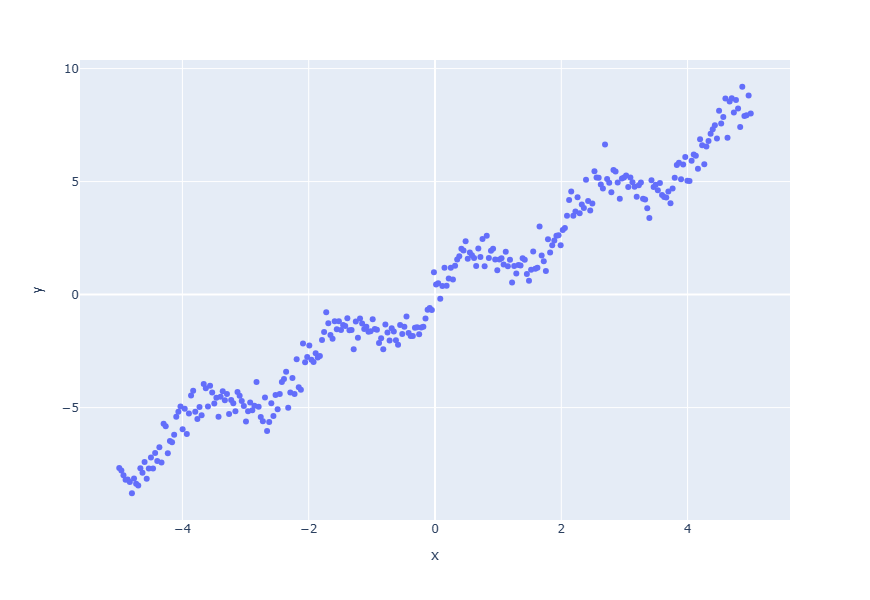

In [51]:
# Run this cell to plot the data; no further action is needed.
import plotly.express as px
px.scatter(df, x="x", y="y", width=800, height=600)

In this exercise, we'll show gradient descent is so powerful it can even optimize a non-linear model (when the analytical solution is hard to derive). Specifically, we're going to model the relationship of our data by:

$$\Large{
\hat{y}_\theta(x) = \theta_1x + \sin(\theta_2x)
}$$

Our model is parameterized by $\theta = \begin{bmatrix} \theta_1 \\ \theta_2 \end{bmatrix}$.

Note that a general `sin` function $a\sin(bx+c)$ has three parameters: amplitude scaling parameter $a$, frequency parameter $b$, and phase shifting parameter $c$. 
Here, we're assuming the amplitude $a$ is around 1, and the phase shifting parameter $c$ is around zero. We do not attempt to justify this assumption and you're welcome to see what happens if you ignore this assumption at the end of this lab.

We define the `sin_model` function below that outputs predictions $\hat{\mathbb{Y}}$ for the $y$-values $\mathbb{Y}$ using $\mathbb{X}$ (the $x$-values) based on our new equation.

In [52]:
# Run this cell to define the model; no further action is needed.
def sin_model(X, theta):
    """
    Outputs predictions (Y-hat) given X, theta_1, theta_2.

    Keyword arguments:
    x -- The vector of values x.
    theta -- A vector of length 2, where theta[0] = theta_1 and theta[1] = theta_2.
    """
    theta_1 = theta[0]
    theta_2 = theta[1]
    return theta_1 * X + np.sin(theta_2 * X)

You might ask - Why we don't just represent this as a linear model with a sinusoidal feature, just like we did earlier? The issue is that the theta is INSIDE the `sin` function, and hence this formulation is **not linear in theta**. In other words, linear models use their parameters to adjust the scale of each feature, but $\theta_2$ in this model adjusts the frequency of the feature. There are tricks we could play to use our linear model framework here, but we won't attempt this in our lab.

### Terminology: Loss

We use the word "loss" in two different (but very related) contexts in this course.
* In general, the loss is the cost function that measures how far off a model's prediction(s) is(are) from the actual value(s).
    * **Per-datapoint loss** is a cost function that measures the cost of $y$ vs $\hat{y}$ for a particular datapoint. For example, $L(y, \hat{y}) = (y - \hat{y})^2$ is the L2 loss of the observed and predicted pair ($y$, $\hat{y}$).
    * **Loss** (without any adjectives) is generally a cost function measured across all data points. We often use this term interchangeably with **empirical risk** to denote the average per-datapoint loss. For example, MSE can be denoted as $MSE(\theta) = L(\theta) = R(\theta) = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2$
* If we're being particular about notation, we usually prioritize using the latter definition, because we don't particularly look at a given data point's loss when optimizing a model. In other words, the dataset-level loss is the **objective function** that we'd like to minimize.
    * Example: "gradient of L2 loss" means gradient of Mean Squared Error, not per-datapoint L2 loss.
* In this particular lab, however, we'll stick to using $L(\theta)$ for consistency with the lecture. In future work, we will be clearer about the distinction.

<br>

---
### Question 4a: Computing the Gradient of the MSE With Respect to Theta on the Sine Model

Recall $\hat{\theta}$ is the value of $\theta$ that minimizes our loss function. One way to solve for $\hat{\theta}$ is by computing the gradient of our loss function with respect to $\theta$, like we did in Lecture 13. Recall that the gradient is a column vector of partial derivatives (one partial derivative per parameter).

**Task**: Write/derive the expressions for the following values and use them to fill in the functions below. Working out the partial derivatives on paper is a great starting point for implementing `sin_MSE_dt1` and `sin_MSE_dt2`!

* $L(\theta)$ as `sin_mse`: Our cost function, mean squared error, where `theta` represents $\theta = \begin{bmatrix} \theta_1 \\ \theta_2 \end{bmatrix}$. 
Recall that $$L(\vec{\theta}, \mathbb{X}, \mathbb{Y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2.$$
* $\frac{\partial L }{\partial \theta_1}$ as `sin_MSE_dt1`: The partial derivative of $L$ with respect to $\theta_1$.
* $\frac{\partial L }{\partial \theta_2}$ as `sin_MSE_dt2`: The partial derivative of $L$ with respect to $\theta_2$.
* We have completed for you `sin_MSE_gradient`, which computes $\nabla_{\vec{\theta}} L(\vec{\theta}, \mathbb{X}, \mathbb{Y})$  by calling `dt1` and `dt2` and returns the gradient `dt`.

**Notes:**
* We are still working with the `DataFrame` `df`.
* To keep our code more concise, use `np.mean` instead of taking `np.sum` and then dividing by the length of the `NumPy` array.
* Another way to keep your code more concise is to use the function `sin_model` we defined which computes the output of the model.
* Review the "Terminology: Loss" section above.

In [58]:
def sin_MSE(theta, X, Y):
    """
    Returns the numerical value of the l2 loss of our sinusoidal model given theta.

    Keyword arguments:
    theta -- The vector of values theta.
    X     -- The vector of x values - note that sin_model only needs a vector of X values and handles the transformations.
    Y     -- The vector of y values.
    """
    return np.sum((Y-sin_model(X,theta))**2)/len(Y)
    ...

def sin_MSE_dt1(theta, X, Y):
    """
    Returns the numerical value of the partial derivative of l2 loss with respect to theta_1.

    Keyword arguments:
    theta -- The vector of values theta.
    X     -- The vector of x values.
    Y     -- The vector of y values.
    """
    return -np.dot((Y-sin_model(X,theta)),X)*2/len(X)
    
def sin_MSE_dt2(theta, X, Y):
    """
    Returns the numerical value of the partial of l2 loss with respect to theta_2.

    Keyword arguments:
    theta -- The vector of values theta.
    X     -- The vector of x values.
    Y     -- The vector of y values.
    """
    return -np.dot((Y-sin_model(X,theta)),np.cos(theta[1] * X)*X)*2/len(X)
    
# This function calls dt1 and dt2 and returns the gradient dt.
# It is already implemented for you.
def sin_MSE_gradient(theta, X, Y):
    """
    Returns the gradient of l2 loss with respect to vector theta.

    Keyword arguments:
    theta -- The vector of values theta.
    X     -- The vector of x values.
    Y     -- The vector of y values.
    """
    return np.array([sin_MSE_dt1(theta, X, Y), sin_MSE_dt2(theta, X, Y)])

In [59]:
grader.check("q4a")

q4a results: All test cases passed!

<br>

---
### Question 4b: Implementing Gradient Descent and Using It to Optimize the Sine Model

Let's now implement gradient descent. 

Recall that the gradient descent update function follows the form:

$$\large
\vec{\theta}^{(t+1)} \leftarrow \vec{\theta}^{(t)} - \alpha \left (\nabla_{\vec{\theta}} L(\vec{\theta}, \mathbb{X}, \mathbb{Y}) \right )
$$
where 

- $\vec{\theta}^{(t+1)}$: Our new coefficients after making an update.
- $\vec{\theta}^{(t)}$: Our current coefficients.
- $\alpha$: Our step size or learning rate.
- $\nabla_{\vec{\theta}} L(\vec{\theta}, \mathbb{X}, \mathbb{Y})$: The gradient of our loss.

At each time step, use the gradient and `alpha` to update your current `theta`. Save the current `theta` in `theta_history`, along with the average squared loss (computed with the current `theta`) in `loss_history`.

After completing the function, the cell will output the trajectory from running gradient descent over time.


Note that the function you're implementing here is somewhat different than the gradient descent function we created in the lecture. The version in the lecture was `gradient_descent(df, initial_guess, alpha, n)`, where `df` was the gradient of the function we are minimizing and `initial_guess` are the starting parameters for that function. Here our signature is a bit different (described below in docstring) than the `gradient_descent` implementation from the lecture.

**Hints:**
- Write out the gradient update equation (1 step). What variables will you need for each gradient update? Of these variables, which ones do you already have, and which ones will you need to recompute at each time step?
- You may need a loop here to update `theta` several times. Take a look at `num_iter`.
- Be sure to include the initial theta and loss into the trajectory because the test checks for this.
- Don't forget that `sin_MSE` and `sin_MSE_gradient` require the $x$ and $y$ values to be supplied.

In [65]:
def init_theta():
    """Creates an initial theta [0, 0] of shape (2,) as a starting point for gradient descent."""
    return np.array([0, 0])

def grad_desc(loss_f, gradient_loss_f, theta, data, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and static learning rate.

    Keyword arguments:
    loss_f -- The loss function to be minimized (used for computing loss_history).
    gradient_loss_f -- The gradient of the loss function to be minimized.
    theta -- The vector of values theta to use at the first iteration.
    data -- The data used in the model. 
    num_iter -- The max number of iterations.
    alpha -- The learning rate (also called the step size).
    
    Return:
    theta -- The optimal value of theta after num_iter of gradient descent.
    theta_history -- The list of theta values over each iteration of gradient descent.
    loss_history -- The list of loss values over each iteration of gradient descent.
    """
    theta_history = []
    loss_history = []
    X=data['x'].to_numpy()
    Y=data['y'].to_numpy()
    for i in range(num_iter):
        theta_history.append(theta)
        loss_history.append(loss_f(theta,X,Y))
        theta=theta-alpha*gradient_loss_f(theta,X,Y)
    theta_history.append(theta)
    loss_history.append(loss_f(theta,X,Y))
        
    ...
    return theta, theta_history, loss_history

theta_start = init_theta()
theta_hat, thetas_used, losses_calculated = grad_desc(
    sin_MSE, sin_MSE_gradient, theta_start, df, num_iter=20, alpha=0.1
)
for b, l in zip(thetas_used, losses_calculated):
    print(f"theta: {b}, Loss: {l}")

theta: [0 0], Loss: 20.859191416422235
theta: [2.60105745 2.60105745], Loss: 9.285008173048674
theta: [0.90342728 2.59100602], Loss: 4.680169273815366
theta: [2.05633644 2.9631291 ], Loss: 2.624251793632583
theta: [1.15892347 2.86687431], Loss: 1.4765157174727785
theta: [1.79388042 3.07275573], Loss: 0.9073271435862448
theta: [1.32157494 3.00146569], Loss: 0.541531643291128
theta: [1.64954491 3.02910866], Loss: 0.3775841142469479
theta: [1.42325294 2.98820303], Loss: 0.2969750688130759
theta: [1.58295041 3.01033846], Loss: 0.2590425421375732
theta: [1.47097255 2.98926519], Loss: 0.23973439443291833
theta: [1.55040965 3.0017442 ], Loss: 0.23034782416254634
theta: [1.49439132 2.99135194], Loss: 0.2255775832667724
theta: [1.5341564  2.99797824], Loss: 0.22321772191904068
theta: [1.50603995 2.99286671], Loss: 0.22202363967204045
theta: [1.52598919 2.99628665], Loss: 0.22142811500262397
theta: [1.51186655 2.99375531], Loss: 0.22112776381775168
theta: [1.52188208 2.99549617], Loss: 0.2209774

In [66]:
grader.check("q4b")

q4b results: All test cases passed!

Let's visually inspect our results of running gradient descent to optimize $\vec{\theta}$. The code below plots our $x$-values with our model's predicted $\hat{y}$-values over the original scatter plot. You should notice that gradient descent successfully optimized $\vec{\theta}$.

In [67]:
theta_init = init_theta()
theta_est, thetas, loss = grad_desc(sin_MSE, sin_MSE_gradient, theta_init, df)

Plotting our model output over our observations shows that gradient descent did  a great job finding both the overall increase (slope) of the data, as well as the oscillation frequency.

<>:4: SyntaxWarning:

invalid escape sequence '\h'

<>:4: SyntaxWarning:

invalid escape sequence '\h'

C:\Users\siriusyz\AppData\Local\Temp\ipykernel_33416\1106403361.py:4: SyntaxWarning:

invalid escape sequence '\h'



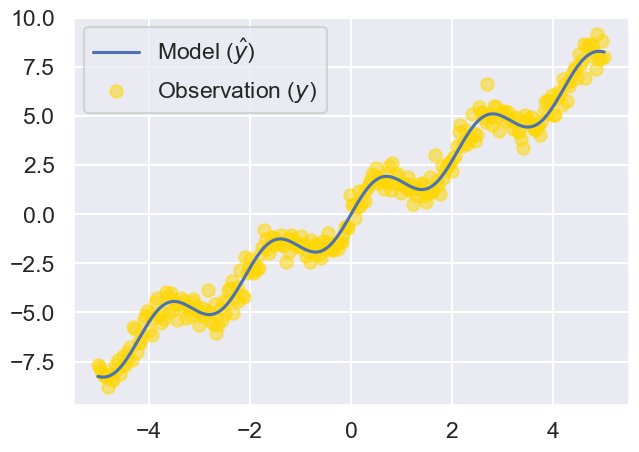

In [68]:
X, Y = df['x'], df['y']
Y_pred = sin_model(X, theta_est)

plt.plot(X, Y_pred, label='Model ($\hat{y}$)')
plt.scatter(X, Y, alpha=0.5, label='Observation ($y$)', color='gold')
plt.legend();

## Visualizing Loss

Let's visualize our loss functions and gain some insight as to how gradient descent optimizes our model parameters.

In the previous plot, we saw the loss decrease with each iteration. In this part, we'll see the trajectory of the algorithm as it travels the loss surface. Run the following cells to see a visualization of this trajectory. 

In [69]:
thetas = np.array(thetas).squeeze()
loss = np.array(loss)
thetas

array([[0.        , 0.        ],
       [2.60105745, 2.60105745],
       [0.90342728, 2.59100602],
       [2.05633644, 2.9631291 ],
       [1.15892347, 2.86687431],
       [1.79388042, 3.07275573],
       [1.32157494, 3.00146569],
       [1.64954491, 3.02910866],
       [1.42325294, 2.98820303],
       [1.58295041, 3.01033846],
       [1.47097255, 2.98926519],
       [1.55040965, 3.0017442 ],
       [1.49439132, 2.99135194],
       [1.5341564 , 2.99797824],
       [1.50603995, 2.99286671],
       [1.52598919, 2.99628665],
       [1.51186655, 2.99375531],
       [1.52188208, 2.99549617],
       [1.51478773, 2.99423497],
       [1.51981739, 2.99511516],
       [1.51625373, 2.99448441]])

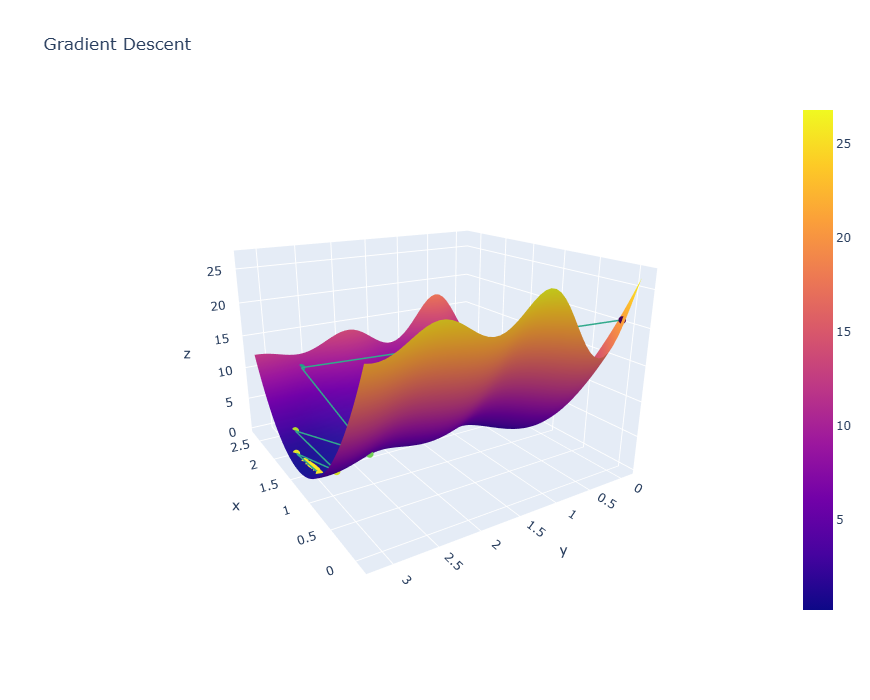

In [70]:
# Run this cell to see a 3D plot (gradient descent with static alpha).
from lab7_utils import plot_3d
plot_3d(thetas[:, 0], thetas[:, 1], loss, mean_squared_error, sin_model, X, Y)

In [71]:
def contour_plot(title, theta_history, loss_function, model, X, Y):
    """
    The function takes the following as argument:
        theta_history: An (N, 2) array of theta history.
        loss: A list or array of loss values.
        loss_function: For example, l2_loss.
        model: For example, sin_model.
        X: The original X input.
        Y: The original Y output.
    """
    theta_1_series = theta_history[:,0] # A list or array of theta_1 value
    theta_2_series = theta_history[:,1] # A list or array of theta_2 value

    ## In the following block of code, we generate the z-value
    ## across a 2D grid
    theta1_s = np.linspace(np.min(theta_1_series) - 0.1, np.max(theta_1_series) + 0.1)
    theta2_s = np.linspace(np.min(theta_2_series) - 0.1, np.max(theta_2_series) + 0.1)

    x_s, y_s = np.meshgrid(theta1_s, theta2_s)
    data = np.stack([x_s.flatten(), y_s.flatten()]).T
    ls = []
    for theta1, theta2 in data:
        l = loss_function(model(X, np.array([theta1, theta2])), Y)
        ls.append(l)
    z = np.array(ls).reshape(50, 50)

    fig1, ax = plt.subplots(figsize=(30, 10))
    cs = ax.contourf(x_s, y_s, z, levels=20, cmap='viridis')
    ax.scatter(theta_1_series, theta_2_series, c='w')
    ax.plot(theta_1_series, theta_2_series, c='w')

    cbar = fig1.colorbar(cs)

    plt.title(title)

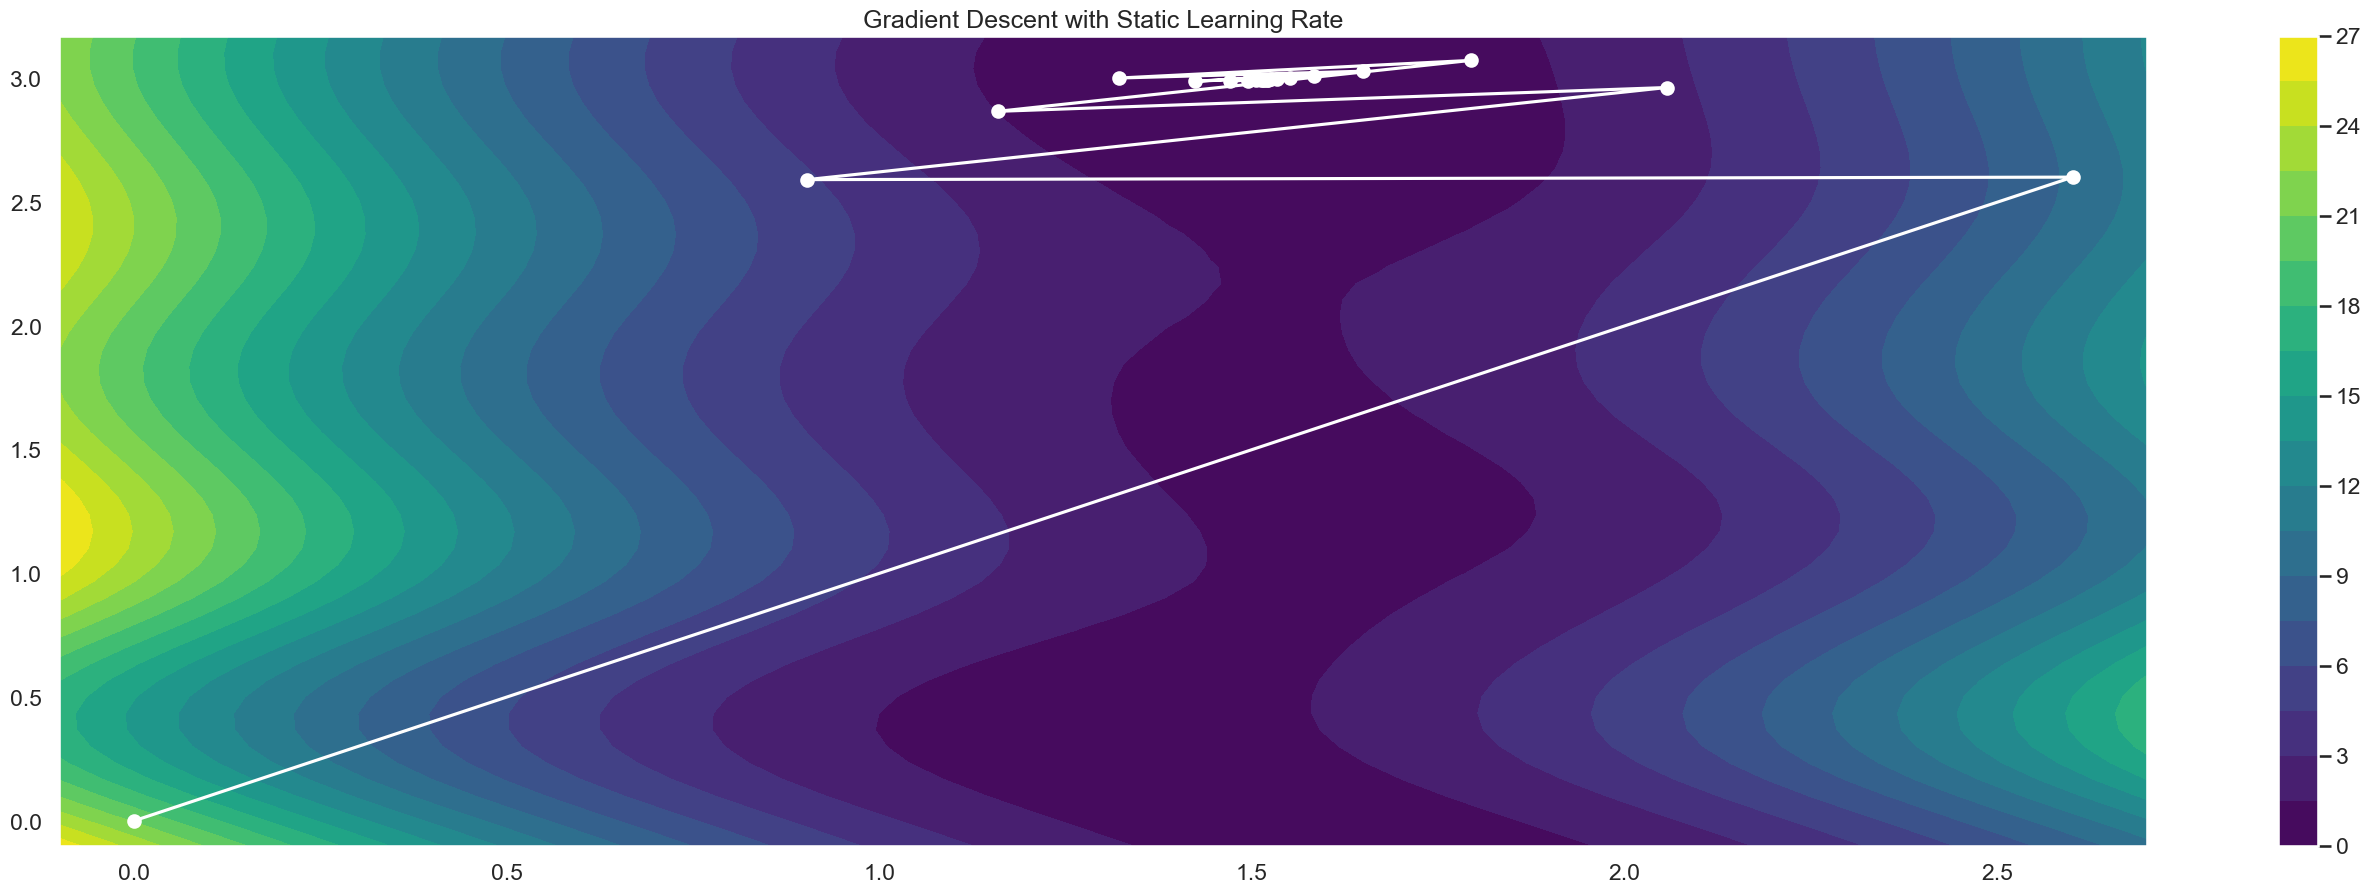

In [72]:
contour_plot('Gradient Descent with Static Learning Rate', thetas, mean_squared_error, sin_model, df["x"], df["y"])

As we can see, gradient descent is able to navigate even this fairly complex loss space and find a nice minimum.

### Bonus:
To save some computational time, you will often see two modifications in the standard library:

* Instead of always making some fixed number of iterations, we can terminate early if we determine that `theta` already converges. Convergence is usually defined by $\theta_{t+1} - \theta_{t}$ is less than some number, and you can specify this in the `tol` argument in `scipy.optimize.minimize` function. The maximum iteration can be set using the `maxiter` parameter as well.
* Instead of calculating the risk by averaging over all data points, we estimate the risk by averaging over some subsample of data points. This is known as stochastic gradient descent and is usually denoted as SGD. See the relevant lecture slides for a more precise definition of SGD in the context of Data 100.


<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Ruby congratulates you for finishing Lab 07!

<img src='ruby.jpeg' width="400px" />

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/1dvvrkvDPlCHzyGjigg9U5UODHB7njceowiigNn6LWe4/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Submit this file to the Lab 07 assignment on Gradescope. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)